# DSCP Final Project
Author : cdp(41075901H)

## Introduction
Hello everyone, my name is Peng Chang De. \\
Because I usually invest in stocks, sometimes I use technical indicators (TIs) as the basis for buying and selling, such as 5MA, 10MA, KD and RSI, but some apps provided by stock underwriters do not provide such charts. Through the final project I want to visualize stock information. \\
I will implement:
- Draw a candlestick chart through the Open, High, Low, Close of the stock price
- 5MA, 10MA, 20MA
- KD, RSI
- Use Prophetm to predict stock prices

## How to use
1. Enter the Taiwan stock code you want to query \\
(Example: If you want to inquire the information of Yuanta/P-shares Taiwan Top 50 ETF, you must enter `0050`)
2. Enter the time you want to start and end \\
(Example: `2022-10-1 ~ 2022-12-1`, )
3. Enjoy!

Note: Please **make sure your input is valid**, otherwise you will be asked to re-enter the value until you figure it out.

## STEP0: Install Ta-lib and twstock

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
!pip install twstock
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install --upgrade mplfinance
!pip install prophet

## STEP1: Import the modules

In [ ]:
import numpy as np
import pandas as pd

# get data
import pandas_datareader as pdr

# visual
import matplotlib.pyplot as plt
import mplfinance as mpf
%matplotlib inline
import seaborn as sns

#time
import datetime as datetime

#talib (Use step 0 to make sure you have installed this package)
from talib import abstract

import twstock
code_list = twstock.codes # create stock code list (type:dict)

## STEP2: Enter the stock code and query range

In [ ]:
condition = True
## input data
while condition == True:
  stock_code = input('Please enter the stock code.(format:xxxx): ')
  start_time = list(map(int,input('Please enter the starting time you want to query.(format:yyyy-mm-dd): ').split('-')))
  end_time = list(map(int,input('Please enter the end time you want to query.(format:yyyy-mm-dd): ').split('-')))
  print('Please confirm this is the input you want:','stock_code =',stock_code,'start_time =',start_time,'end_time =',end_time)
  ## check whether valid or not
  if(input('Please enter Y/N: ').upper()=='Y'):
    condition = False
  else:
    continue
  if(len(start_time)!=3 or len(end_time)!=3):
    condition = True
    continue
  if(not(stock_code in twstock.codes)):
    condition = True
    continue
  start_time = datetime.date(start_time[0], start_time[1], start_time[2])
  end_time = datetime.date(end_time[0], end_time[1], end_time[2])
  initial_time = list(map(int,code_list[stock_code].start.split('/')))
  initial_time = datetime.date(initial_time[0],initial_time[1],initial_time[2])
  now_time = datetime.date.today( ) - datetime.timedelta(days=1)
  if(start_time >= end_time or start_time < initial_time or start_time > now_time or end_time < initial_time or end_time > now_time):
    condition = True
    continue
print('Pass the input validation!')

Please enter the stock code.(format:xxxx): 2330
Please enter the starting time you want to query.(format:yyyy-mm-dd): 2020-1-1
Please enter the end time you want to query.(format:yyyy-mm-dd): 2020-12-1
Please confirm this is the input you want: stock_code = 2330 start_time = [2020, 1, 1] end_time = [2020, 12, 1]
Please enter Y/N: y
Pass the input validation!


## STEP3: Catch data using twstock

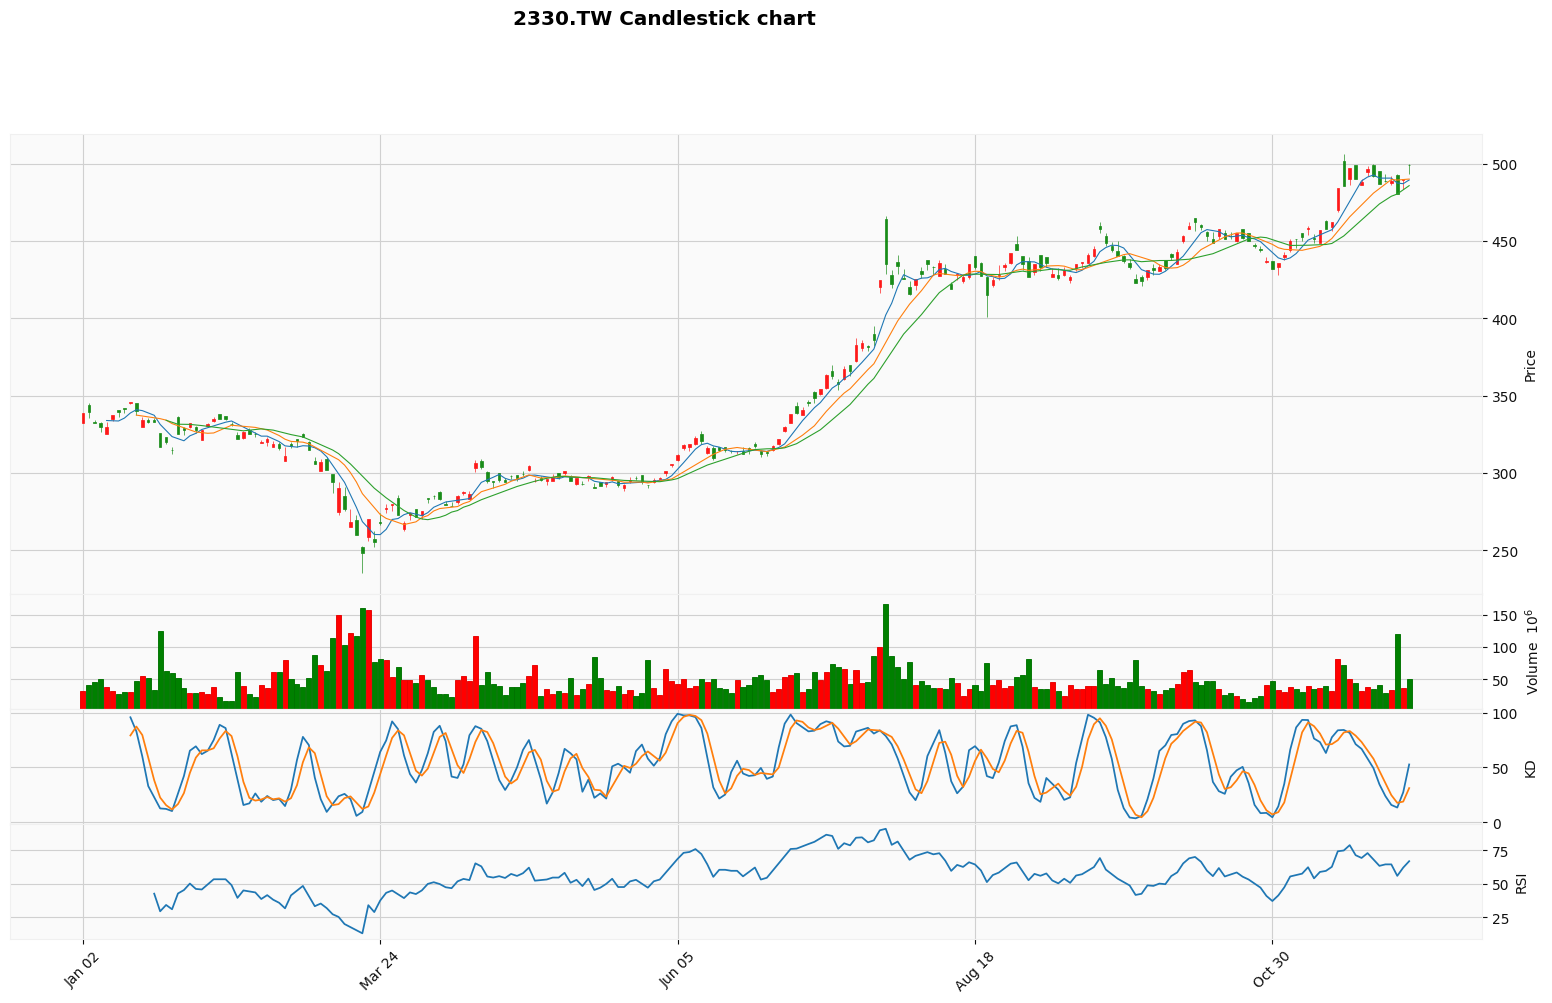

In [ ]:
## Some function for TIs
def KD(df):
  period = 9
  return abstract.STOCH(df,timeperiod=period)

def RSI(df):
  period = 12
  return abstract.RSI(df, timeperiod=period)

# df_stock contains Date,High,Low,Open,Close,Volume,Adj Close
df_stock = pdr.DataReader(str(stock_code)+'.TW', 'yahoo', start_time, end_time)
# set plot style
mc = mpf.make_marketcolors(up='r', down='g',inherit=True)
s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# copy and rename df_stock (fit talib input)
df_stock_colName_lower = df_stock.rename(columns={'Open': 'open', 'Low':'low', 'High':'high', 'Close':'close', 'Volume':'volume', 'Adj Close':'adj close'})

# make subplot
add_plot = [mpf.make_addplot(KD(df_stock_colName_lower),panel=2,ylabel='KD'),mpf.make_addplot(RSI(df_stock_colName_lower),panel=3,ylabel='RSI')]
# plot!
kwargs = dict(type='candle', mav=(5,10,15), volume=True, figratio=(16,9), figscale=2, title=(str(stock_code)+'.TW Candlestick chart'), addplot=add_plot, style=s, main_panel=0,volume_panel=1,num_panels=4,panel_ratios=(4,1,1,1))
mpf.plot(df_stock,**kwargs)


In [ ]:
from prophet import Prophet
from sklearn import metrics
from prophet.plot import plot_plotly, plot_components_plotly

## Handle input formatted according to prophet (contains two columns ds(Date) and y(Adj Close))
plt.style.use('ggplot')
new_df = pdr.DataReader(str(stock_code)+'.TW', 'yahoo', initial_time, end_time)
new_df['ds'] = new_df.index
new_df.rename(columns = {'Adj Close':'y'}, inplace = True)

# Use prophet to predict stock price
model = Prophet()
m = Prophet()
m.fit(new_df)
future = m.make_future_dataframe(periods=30)
future.tail(30)
forecast = m.predict(future)

# Plotting using the built-in prophet
plot_plotly(m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxznadoaq/5uwyxcxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxznadoaq/90o_w8so.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74491', 'data', 'file=/tmp/tmpxznadoaq/5uwyxcxs.json', 'init=/tmp/tmpxznadoaq/90o_w8so.json', 'output', 'file=/tmp/tmpxznadoaq/prophet_model71jdckev/prophet_model-20221208161130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:11:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
